# Model Error Analysis

In this notebook we analyse the model susceptibility to perturbed images. In other words, we record the change in accuracy with respext to the modified input using the augmentation techniques provided by Albumentations. We test the following methods: 

- **ColorJitter**: Randomly changes the brightness, contrast, and saturation of an image.
- **GaussNoise**: Apply gaussian noise to the input image.
- **ChannelShuffle**: Randomly rearrange channels of the input RGB image.
- **HueSaturationValue**: Randomly change hue, saturation and value of the input image.
- **ImageCompression**: Decreases image quality by Jpeg, WebP compression of an image.
- **Downscale**: Decreases image quality by downscaling and upscaling back.

More information on Albumentations can be found in the documentation https://albumentations.ai/docs/api_reference/augmentations/transforms/

In [334]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import albumentations as A

from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy

from predict import load_model_effnet, load_model_scratch

In [228]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # automatically select on what device to run the code

## Evaluation on the original data

The function below computes the total accuracy over the whole valid set and the accuracy over each class using the built-in method MulticlassAccuracy from torchmetrics . And outputs the list of results, where the last value is total accuracy. 
$$ Accuracy = \sum_{i}^{N} 1(y_{i} = \hat{ y_{i}})$$
Where $y$ is a tensor of target values, and $\hat{y}$ is a tensor of predictions.

In [337]:
def test(data_loader, model, print_acc = True):
    model = model.to(device)
    model.eval()
    correct = 0
    preds = []
    gts = []
    metric = MulticlassAccuracy(num_classes=13, average=None)
    for images, labels in data_loader:
        images, labels =  images.to(device), labels.to(device)
        output = model(images)
        pred = output.data.max(1)[1]
        preds.append(pred)
        gts.append(labels)
        correct += pred.eq(labels.data).cpu().sum()
    
    x = torch.reshape(torch.stack(preds,0), [-1,1])
    y = torch.reshape(torch.stack(gts,0), [-1,1])
    acc_per_class = metric(x.cpu(), y.data.cpu())
    results = list(100*np.array(acc_per_class))
    tot_acc = float(100. * correct / len(data_loader.dataset))
    results.append(tot_acc)
    if print_acc:
        print('\nValid set: Accuracy for the whole set : {}/{} ({:.2f}%)\n'.format(correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset)))

    return results 

Record the accuracy of the model from scratch and pretrained model on the original data before applying augmentations

In [244]:
PATH_TO_VALID = '../data/new_data/valid-lab/'
valid_set = datasets.ImageFolder(root=PATH_TO_VALID, transform=transforms.ToTensor())
valid_data = DataLoader(valid_set, batch_size=16, shuffle=True, num_workers=2)

In [245]:
model_scratch = load_model_scratch()
model_effnet = load_model_effnet()

In [338]:
x_scratch = test(valid_data, model_scratch)


Valid set: Accuracy for the whole set : 866/1040 (83.27%)



In [339]:
x_effnet = test(valid_data, model_effnet)


Valid set: Accuracy for the whole set : 1005/1040 (96.63%)



## Modify the input

For this experiment we decided to use **Albumentations** as it provides wider range of augmentation methods in comparison to **PyTorch**. However, since the Albumentations accepts different input format incompatible to the pytorch method ImageFolder, below we create another class called **A_Transforms** where we can pass the method of augmentation and receive the correct input for ImageFolder. It will be useful further, when we automate the function for testing different methods. 

In [248]:
class A_Transforms:
    def __init__(self, aug_type):
        self.transforms = aug_type

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

Let's try to apply Gaussian Noise and observe the change in accuracy.

In [251]:
new_valid_set_noisy = datasets.ImageFolder(root=PATH_TO_VALID, transform = transforms.Compose([A_Transforms(A.GaussNoise(p=1)), transforms.ToTensor()]))
new_valid_loader_noisy = DataLoader(new_valid_set_noisy, batch_size=16, shuffle=True, num_workers=2)

In [340]:
x_scratch_perturbed = test(new_valid_loader_noisy, model_scratch)
x_effnet_perturbed = test(new_valid_loader_noisy, model_effnet)


Valid set: Accuracy for the whole set : 860/1040 (82.69%)


Valid set: Accuracy for the whole set : 922/1040 (88.65%)



The decrease in ~0.5% and ~5.0% can be observed for the model trained from scratch and the model using the pretrained weights of EfficientNet respectively.

## Accuracy per class analysis

Now, let's try not only analyze the change in total accuracy. But use different augmentations decsribed above to observe the change in accuracies per each class. 

In [341]:
keys = [A.GaussNoise(p=1), A.ChannelShuffle(p=1), A.Downscale(p=1), A.HueSaturationValue(p=1), A.ColorJitter(p=1), A.ImageCompression(p=1)]
names = ['GaussNoise', 'ChannelShuffle', 'Downscale', 'HueSaturationValue', 'ColorJitter', 'ImageCompression']
data_scratch = dict()
data_effnet = dict()
for augment_type, name in zip(keys,names):
    new_valid_set = datasets.ImageFolder(root=PATH_TO_VALID, transform = transforms.Compose([A_Transforms(augment_type), transforms.ToTensor()]))
    new_valid_loader = DataLoader(new_valid_set, batch_size=16, shuffle=True, num_workers=2)
    acc_1 = test(new_valid_loader, model_scratch, print_acc=False) 
    acc_2 = test(new_valid_loader, model_effnet, print_acc=False)
    data_scratch[name] = acc_1
    data_effnet[name] = acc_2

Create the dataframe for convenience using the class names from *valid_set.class_to_idx* and adding the column name for the total Accuracy

In [342]:
columns = list(valid_set.class_to_idx.keys())
columns.append('Total')

In [343]:
df_scratch = pd.DataFrame.from_dict(data_scratch, orient = 'index', columns = columns)
df_effnet = pd.DataFrame.from_dict(data_effnet, orient = 'index', columns = columns)

The table of the results for the model from scratch

In [344]:
df_scratch

,beach,chaparral,cloud,desert,forest,island,lake,meadow,mountain,river,sea,snowberg,wetland,Total
GaussNoise,78.260872,95.714279,88.235298,82.191780,85.185188,88.888893,69.230774,97.50,74.117645,67.500000,93.827156,97.435898,64.473686,83.173080
ChannelShuffle,51.086956,41.428574,82.352943,27.397261,64.197525,53.086418,21.794872,17.50,22.352942,15.000001,83.950615,87.179489,42.105263,47.211540
Downscale,70.652176,88.571426,54.117649,82.191780,12.345679,88.888893,69.230774,62.50,67.058823,56.250000,95.061729,98.717949,75.000000,70.384613
HueSaturationValue,67.391304,85.714287,76.470589,73.972603,61.728394,82.716049,58.974361,81.25,62.352943,47.500000,91.358025,85.897430,65.789474,72.211540
ColorJitter,60.869564,77.142860,72.941177,65.753426,70.370369,83.950615,48.717949,61.25,55.294121,42.500000,86.419754,87.179489,52.631580,66.442307
ImageCompression,80.434784,94.285713,90.588234,82.191780,82.716049,88.888893,76.923080,93.75,74.117645,60.000004,93.827156,94.871796,69.736847,83.173080


The table of results for the model trained using the pretrained weights of EfficientNet respectively.

In [345]:
df_effnet

,beach,chaparral,cloud,desert,forest,island,lake,meadow,mountain,river,sea,snowberg,wetland,Total
GaussNoise,97.826088,100.000000,100.000000,89.041100,92.592590,91.358025,89.743591,87.50,81.176468,82.50,91.358025,96.153847,53.947372,88.846153
ChannelShuffle,90.217392,98.571426,98.823532,64.383560,93.827156,76.543213,69.230774,68.75,57.647060,72.50,98.765434,97.435898,63.157890,80.865387
Downscale,67.391304,1.428571,96.470589,95.890411,20.987654,51.851852,20.512821,95.00,0.000000,3.75,39.506172,0.000000,28.947369,40.673077
HueSaturationValue,98.913040,100.000000,96.470589,86.301369,100.000000,90.123459,89.743591,92.50,85.882355,87.50,97.530869,96.153847,85.526314,92.884613
ColorJitter,93.478264,94.285713,98.823532,76.712326,96.296295,87.654320,89.743591,82.50,72.941177,85.00,98.765434,96.153847,80.263153,88.750000
ImageCompression,100.000000,100.000000,98.823532,91.780823,98.765434,92.592590,98.717949,96.25,92.941177,93.75,100.000000,98.717949,92.105263,96.538460


## Visualization

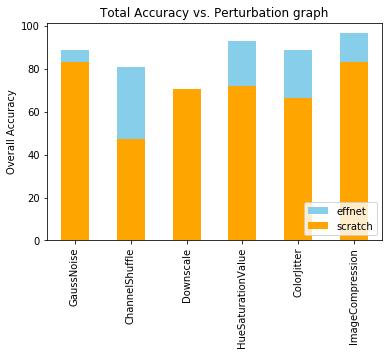

In [346]:
ax = df_effnet['Total'].plot(kind='bar', color = 'skyblue', label='effnet')
plt.title("Total Accuracy vs. Perturbation graph")
df_scratch['Total'].plot(kind='bar', color = 'orange', ax=ax, label = 'scratch')
plt.legend(loc='lower right')
plt.ylabel('Overall Accuracy')
plt.show()

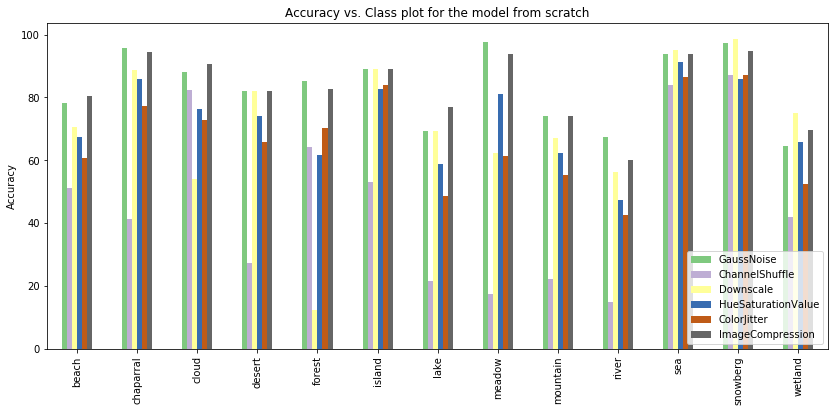

In [347]:
df_s_t = df_scratch[df_scratch.columns[:-1]].T
df_s_t.plot(kind='bar', figsize = (14, 6), cmap=plt.get_cmap('Accent'))
plt.legend(loc= 'lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Class plot for the model from scratch')
plt.show()

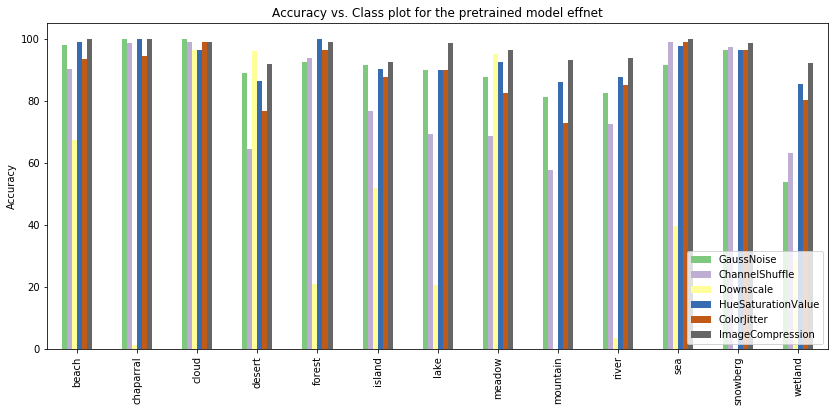

In [348]:
df_e_t = df_effnet[df_effnet.columns[:-1]].T
df_e_t.plot(kind='bar', figsize = (14, 6), cmap=plt.get_cmap('Accent'))
plt.legend(loc= 'lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Class plot for the pretrained model effnet')
plt.show()